# INTRODUCTION


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from biplot import biplot

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Extraction et nettoyage des données

Index(['frequence ecouté artiste émergent', 'tempo',
       'fréquence en travaillant', 'fréquence en sport',
       'fréquence en cuisine', 'fréquence en transport',
       'fréquence en passant le temps', 'age'],
      dtype='object')
(221, 8)
  Dimension  Valeur Propre  % valeur propre  % cum. val. prop.
0      Dim1       2.471420             31.0               31.0
1      Dim2       1.154499             14.0               45.0
2      Dim3       1.003228             13.0               58.0
3      Dim4       0.885845             11.0               69.0
4      Dim5       0.721834              9.0               78.0
(221, 8)
  Dimension  Valeur Propre  % valeur propre  % cum. val. prop.
0      Dim1       2.471420             31.0               31.0
1      Dim2       1.154499             14.0               45.0
2      Dim3       1.003228             13.0               58.0
3      Dim4       0.885845             11.0               69.0
4      Dim5       0.721834              9.0         

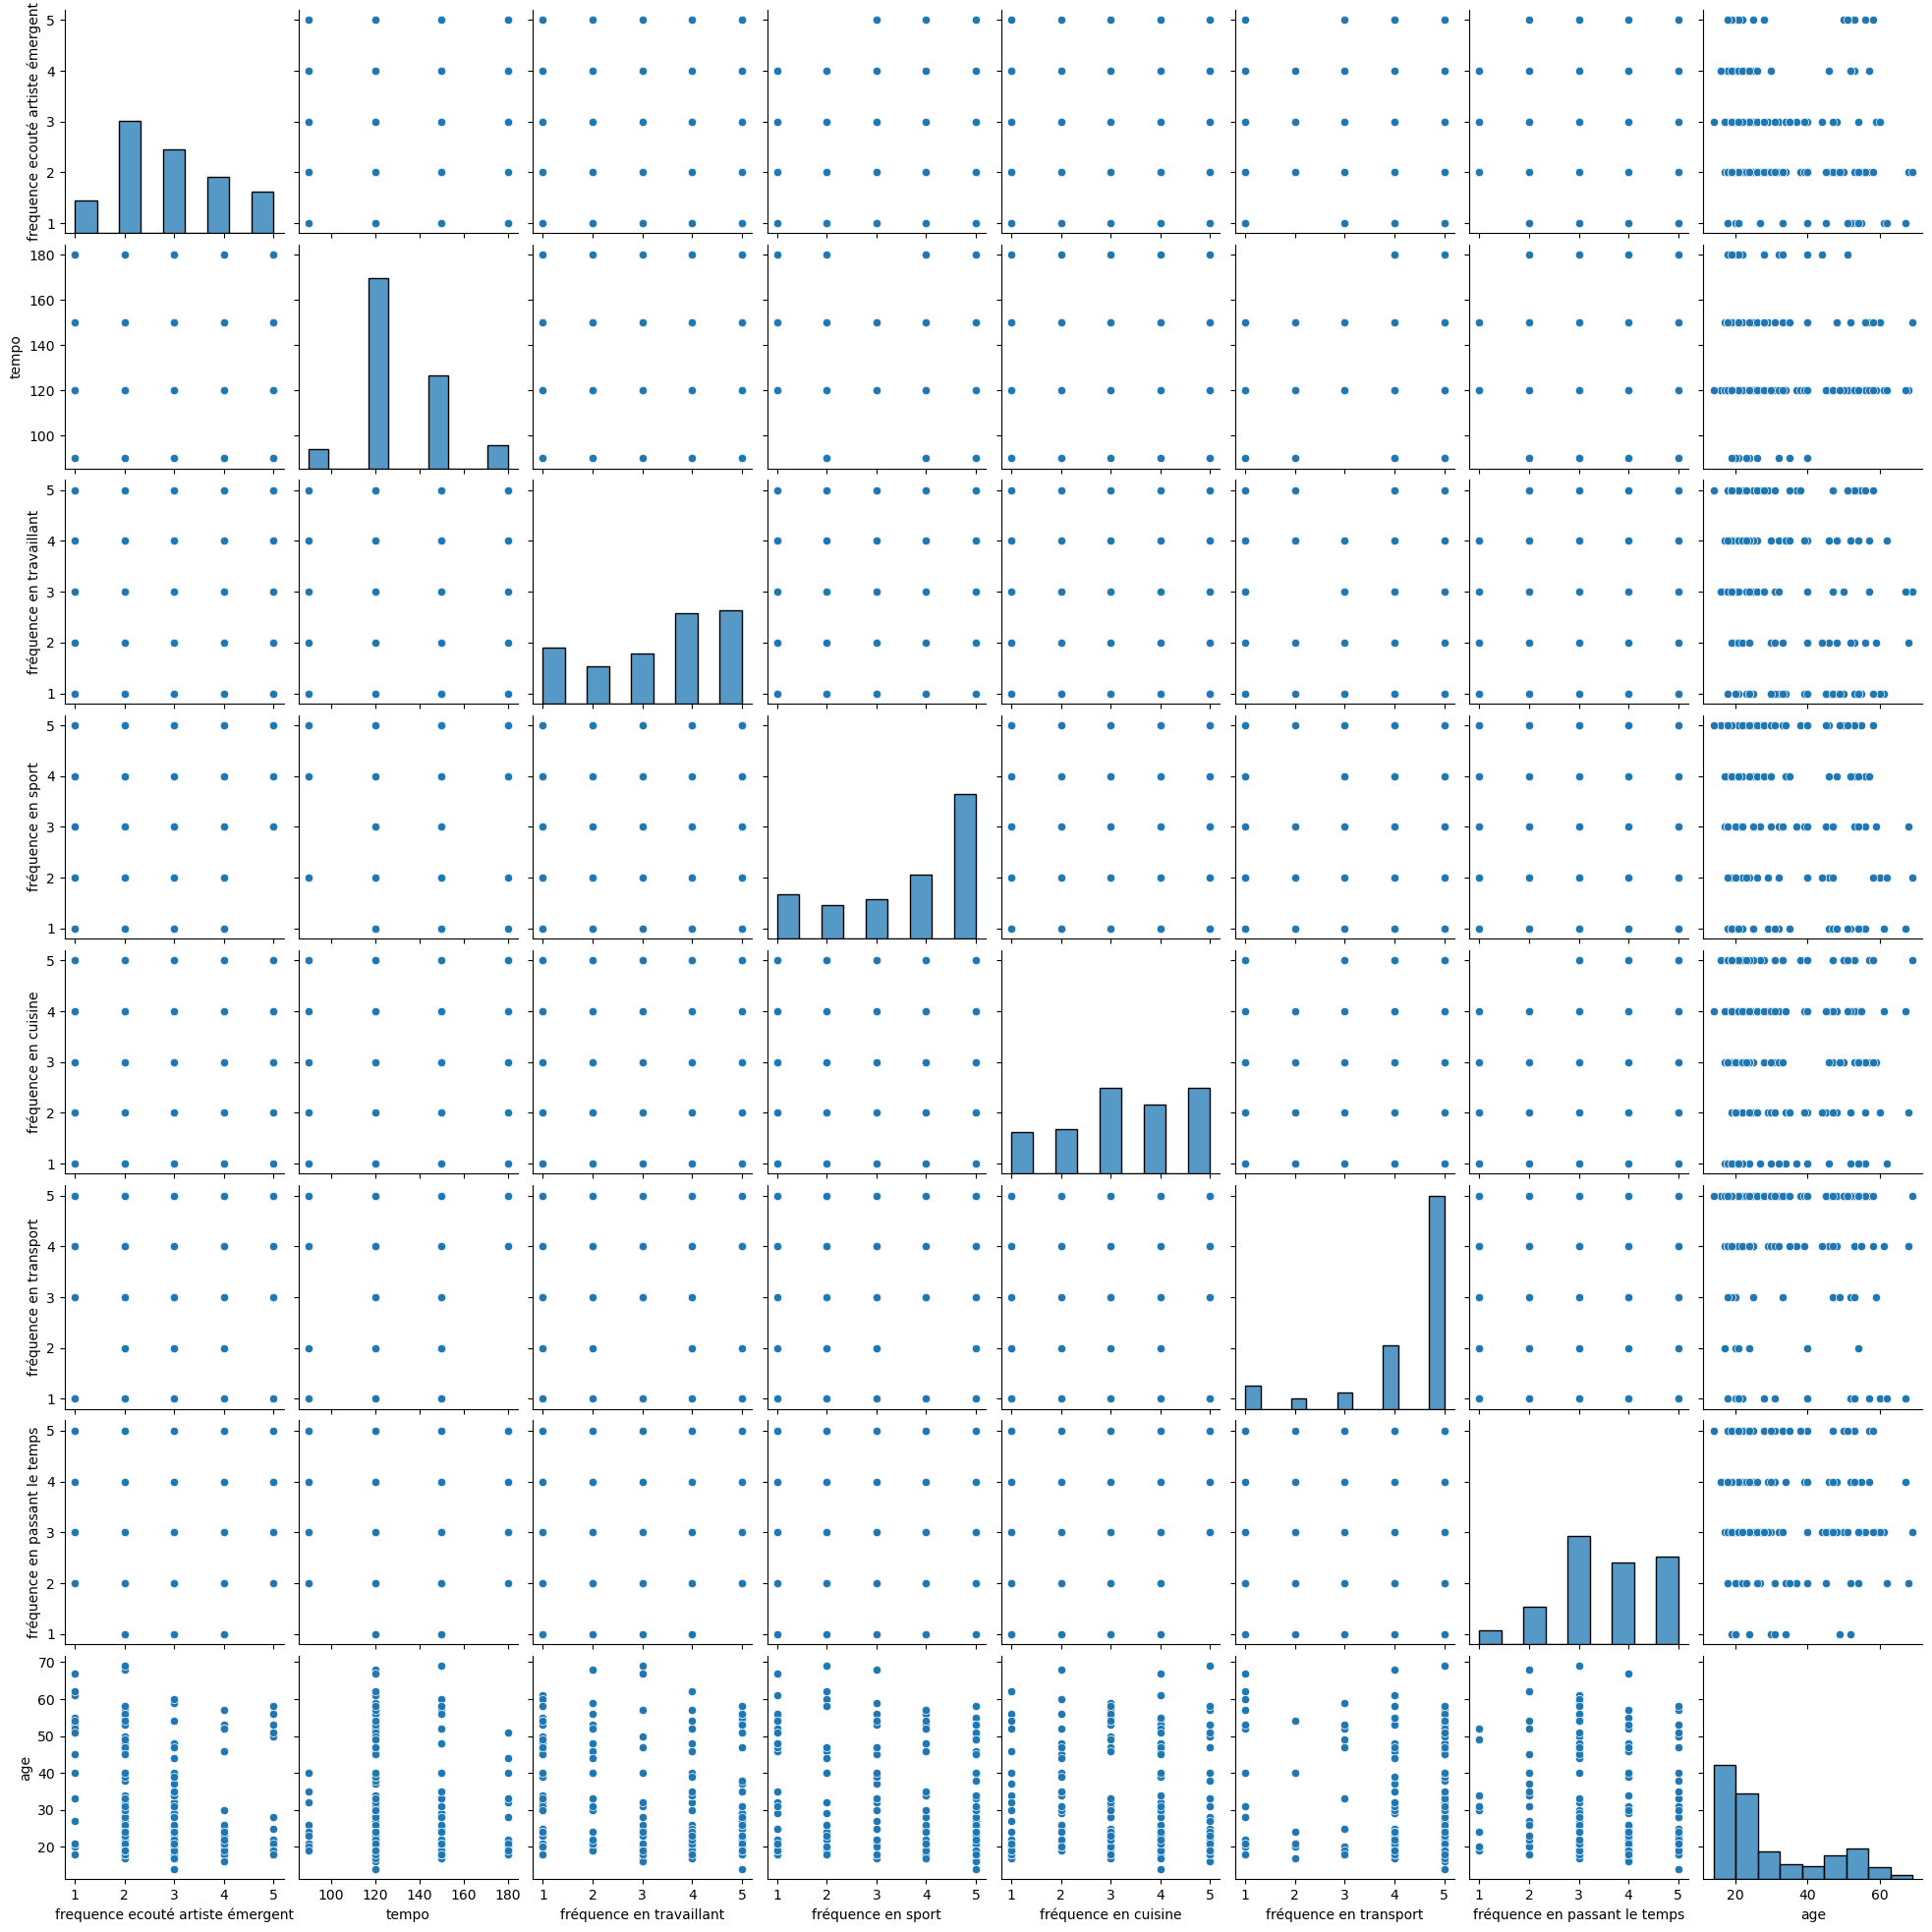

In [3]:
data = pd.read_csv('cleaned_data.csv')
data_quant = data[["frequence ecouté artiste émergent", "tempo", "fréquence en travaillant", "fréquence en sport", "fréquence en cuisine", "fréquence en transport", "fréquence en passant le temps", "age"]].dropna()

n_compo = 5
print(data_quant.columns)
### Visualisation des données
sns.pairplot(data_quant)

temp = data_quant.sub(data_quant.mean())
x_scaled = temp.div(data_quant.std())
print (x_scaled.shape)

pca = PCA(n_components=n_compo)
pca_res = pca.fit_transform(x_scaled)
# print(pca_res)

eig = pd.DataFrame({
    "Dimension" :
        ["Dim" + str(x + 1) for x in range(n_compo)],
    "Valeur Propre" : pca.explained_variance_,
    "% valeur propre" : 
        np.round(pca.explained_variance_ratio_*100),
    "% cum. val. prop." : 
        np.round(np.cumsum(pca.explained_variance_ratio_)*100)
})
print(eig)



### Choix du nombre de components
On a choisi d'avoir cinq components car on arrive à un ratio de 78%, ce qui semble ne pas avoir trop de perte

## Contexte des reponses du questionnaire

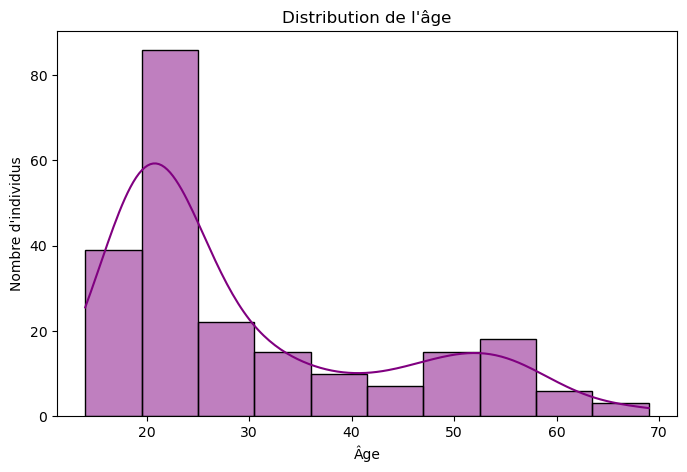

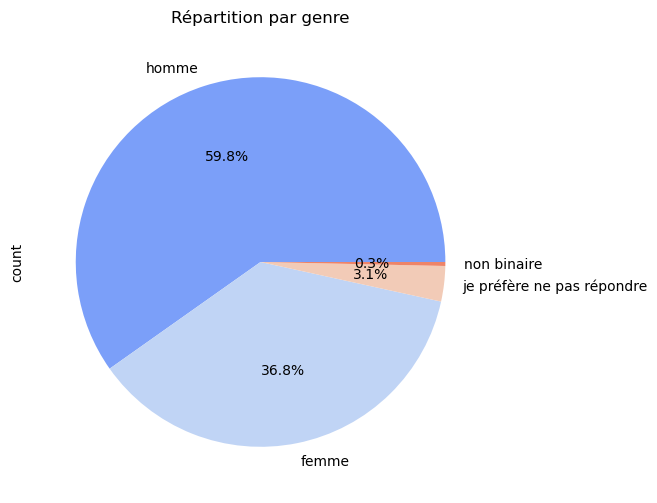

In [19]:
plt.figure(figsize=(8, 5))
sns.histplot(data_quant['age'], bins=10, kde=True, color='purple')
plt.title("Distribution de l'âge")
plt.xlabel("Âge")
plt.ylabel("Nombre d'individus")
plt.show()

plt.figure(figsize=(6, 6))
data['genre'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('coolwarm', len(data['genre'].unique())))
plt.title("Répartition par genre")
plt.show()


## Graphique des variables

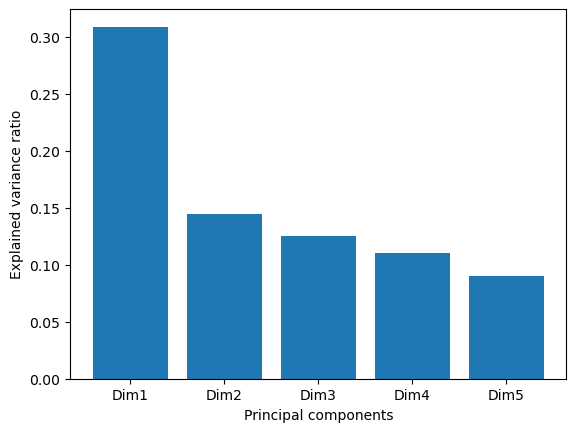

Attention : pour des facilités d'affichage, les données sont centrées-réduites
Warning ! Nombre anormal de catégories !


d:\myli\biplot.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x_c,y_c, c = cat.cat.codes,cmap=cmap)


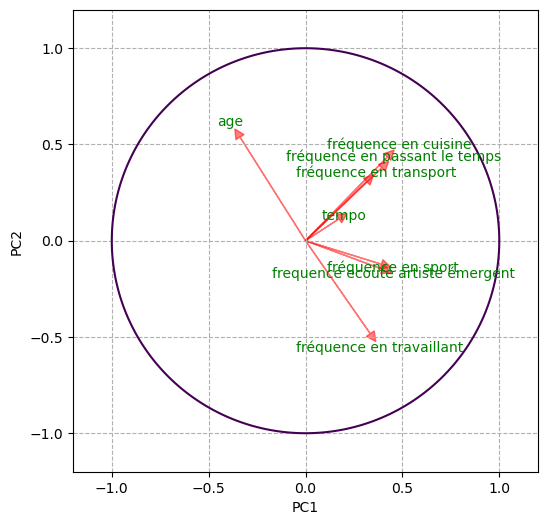

In [15]:
y1 = list(pca.explained_variance_ratio_)
x1 = range(len(y1))
plt.bar(x1, y1)
plt.xticks(list(x1), [f"Dim{i+1}" for i in x1])
plt.xlabel("Principal components")
plt.ylabel("Explained variance ratio")
plt.show()

biplot(score=pca_res[:220, 0:2],
       coeff=np.transpose(pca.components_[0:2, :]),
       cat=data['genre'].iloc[:0],
       coeff_labels=list(data_quant.columns),
       density=False)
plt.show()

## Graphique des individus

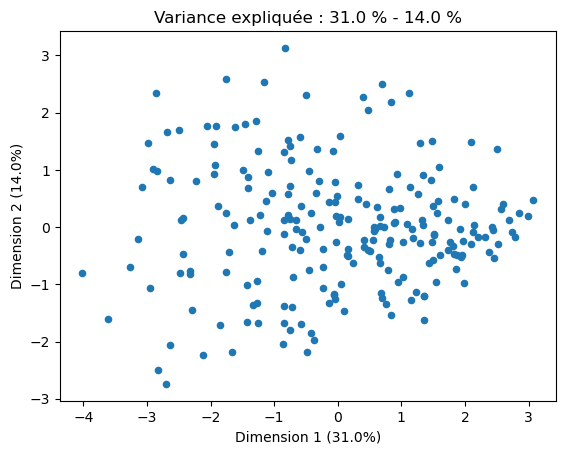

In [11]:
pcadf = pd.DataFrame ({
    "Dim1" : pca_res [:221 , 0 ] ,
    "Dim2" : pca_res [:221 , 1 ] ,
    "genre" : data ["genre"] [:221 ]
})
listVariance = np.round(pca.explained_variance_ratio_*100)
pcadf.plot.scatter ("Dim1", "Dim2")
plt.title (f"Variance expliquée : {listVariance[0]} % - {listVariance[1]} %")
plt.xlabel (f"Dimension 1 ({listVariance[0]}%)")
plt.ylabel (f"Dimension 2 ({listVariance[1]}%)")
plt.show()


Erreur quadratique moyenne (MSE) : 0.06505175631661285
Coefficient de détermination (R²) : -0.04547465508842108

Coefficients des variables :
                                Variable   Coefficient
0                                   age -4.276576e-03
1                                 tempo -4.393751e-04
2                           genre_homme -8.604597e-02
3      genre_je préfère ne pas répondre -9.429395e-02
4                     genre_non binaire -1.179612e-16
5                environnement_banlieue  6.313266e-02
6                environnement_campagne  7.114593e-02
7                   environnement_ville  2.315308e-02
8   situation professionnel_indépendant  1.886682e-01
9      situation professionnel_retraité  1.431161e-01
10      situation professionnel_salarié  1.164241e-01
11  situation professionnel_sans emploi  2.537923e-02
12     situation professionnel_étudiant  5.998657e-02


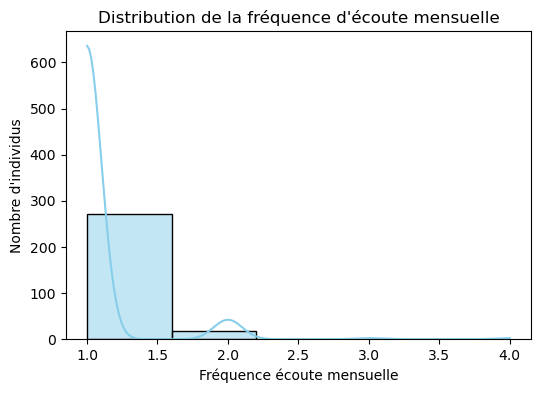

In [14]:
filtered_data = data[['fréquence écoute mensuel', 'age', 'genre', 'environnement',
    'situation professionnel', 'tempo']].dropna()

# 3. Convertir les variables catégorielles en variables numériques (one-hot encoding)
encoded_data = pd.get_dummies(
    filtered_data,
    columns=['genre', 'environnement', 'situation professionnel'],
    drop_first=True
)

# 4. Séparer les variables dépendantes et indépendantes
X = encoded_data.drop('fréquence écoute mensuel', axis=1)
y = encoded_data['fréquence écoute mensuel']

# 5. Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Créer et entraîner le modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# 7. Prédire sur l'ensemble de test
y_pred = model.predict(X_test)

# 8. Calculer les métriques de performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 9. Afficher les coefficients du modèle
coefficients = pd.DataFrame({
    'Variable': X.columns,
    'Coefficient': model.coef_
})

# 10. Afficher les résultats
print("Erreur quadratique moyenne (MSE) :", mse)
print("Coefficient de détermination (R²) :", r2)
print("\nCoefficients des variables :\n", coefficients)

plt.figure(figsize=(6, 4))
sns.histplot(data['fréquence écoute mensuel'], bins=5, kde=True, color='skyblue')
plt.title("Distribution de la fréquence d'écoute mensuelle")
plt.xlabel("Fréquence écoute mensuelle")
plt.ylabel("Nombre d'individus")
plt.show()
